In [26]:
# ───────────────────────── 0. Imports ─────────────────────────
import os, time, re, json, pickle, warnings
from pathlib import Path
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import whisper
import soundfile as sf
import librosa, librosa.display
from IPython.display import Audio, display
from sklearn.metrics import confusion_matrix

# Check GPU / device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

Using device: cpu


In [27]:
# ───────────────────────── 1. Paths & constants ───────────────
AUDIO_DIR = "../data/audio/samples/"
MODEL_DIR = "../models/transformer_sentiment"      # Part-1 sentiment model

RAVDESS_EMOTIONS = {"01": "neutral", "03": "happy", "04": "sad", "05": "angry"}

In [28]:
# ───────────────────────── 2. Optional debug import ───────────
try:
    from SentimentInferenceModel import SentimentInferenceModel as SentModel
    print("Custom SentModel import OK")
except ModuleNotFoundError:
    SentModel = None

Custom SentModel import OK


In [29]:
#  ───────────────────────── 3. Audio metadata ──────────────────
def parse_ravdess_filename(fname: str) -> dict:
    parts = fname.split(".")[0].split("-")
    emotion_code, actor_code = parts[2], parts[6]
    actor_num = int(actor_code)
    return {
        "filename": fname,
        "emotion_code": emotion_code,
        "emotion": RAVDESS_EMOTIONS.get(emotion_code, "unknown"),
        "actor": actor_code,
        "gender": "male" if actor_num <= 12 else "female",
    }

audio_files = sorted(f for f in os.listdir(AUDIO_DIR) if f.endswith(".wav"))
meta_df = pd.DataFrame(parse_ravdess_filename(f) for f in audio_files)
print(f"Loaded {len(meta_df)} audio files"); display(meta_df.head())

Loaded 336 audio files


,filename,emotion_code,emotion,actor,gender
0,03-01-01-01-01-01-01.wav,01,neutral,01,male
1,03-01-01-01-01-01-02.wav,01,neutral,02,male
2,03-01-01-01-01-01-03.wav,01,neutral,03,male
3,03-01-01-01-01-01-04.wav,01,neutral,04,male
4,03-01-01-01-01-01-05.wav,01,neutral,05,male


In [30]:
# ───────────────────────── 3. Whisper setup & transcribe ──────
def load_whisper(size="base"):
    print(f"Loading Whisper-{size} …")
    return whisper.load_model(size, device=DEVICE)

whisper_model = load_whisper("base")

def transcribe(path):
    # Whisper needs str or ndarray
    path = str(path)
    return whisper_model.transcribe(
        path,
        language="en",
        fp16=(DEVICE == "cuda")
    )["text"]

Loading Whisper-base …


In [31]:
# %% ───────────────────────── 4. Sentiment model wrapper ─────────
import tensorflow as tf  # pin >=2.16 in requirements

class CompatibleSentimentModel:
    def __init__(self, model_dir: str):
        p = Path(model_dir)
        if (p / "model.keras").exists():
            self.model = tf.keras.models.load_model(p / "model.keras", compile=False)
        elif (p / "model.h5").exists():
            self.model = tf.keras.models.load_model(p / "model.h5", compile=False)
        else:
            raise FileNotFoundError("No model file found")
        # aux files
        self.word_index = pickle.load(open(p / "word_index.pkl", "rb"))
        self.label_cols = json.load(open(p / "label_cols.json"))
        self.max_len    = json.load(open(p / "config.json"))["max_len"]
        thr = p / "opt_thresholds.npy"
        self.thresholds = np.load(thr) if thr.exists() else None
        print(f"Sentiment model loaded with {len(self.label_cols)} labels")

    # text → ids
    def _prep(self, txt):
        clean = re.sub(r"<.*?>", "", txt.lower())
        clean = re.sub(r"[^a-z0-9\s]", "", clean)
        clean = re.sub(r"\s+", " ", clean).strip()
        ids = [self.word_index.get(tok, 1) for tok in clean.split()]
        ids = (ids[: self.max_len] + [0] * self.max_len)[: self.max_len]
        return np.array([ids], dtype=np.int16)

    def predict(self, text, top_k=3):
        scores = self.model.predict(self._prep(text), verbose=0)[0]
        if self.thresholds is not None:
            above = [(lbl, float(s)) for lbl, s, t in zip(self.label_cols, scores, self.thresholds) if s >= t]
        else:
            above = [(lbl, float(s)) for lbl, s in zip(self.label_cols, scores) if s >= 0.5]
        top = sorted(zip(self.label_cols, map(float, scores)), key=lambda x: x[1], reverse=True)[:top_k]
        return {"raw": dict(zip(self.label_cols, map(float, scores))),
                "above": above,
                "top": top}

sent_model = CompatibleSentimentModel(MODEL_DIR)
sent_model.thresholds = None 

Sentiment model loaded with 28 labels


In [32]:
# %% ───────────────────────── 5. End-to-end pipeline ─────────────
def speech_to_sentiment(path: str):
    txt = transcribe(path)
    senti = sent_model.predict(txt)
    return {"file": Path(path).name, "text": txt, "top": senti["top"]}

results = [speech_to_sentiment(Path(AUDIO_DIR) / f) for f in audio_files]

res_df = pd.DataFrame({
    "filename": [r["file"] for r in results],
    "transcribed_text": [r["text"] for r in results],
    "top_emotion": [r["top"][0][0] for r in results],
    "top_score":   [r["top"][0][1] for r in results],
}).merge(meta_df, on="filename")

In [37]:
# %% ───────────────────────── 6. Build statement-aware reference texts ──
# RAVDESS has two sentences:
STATEMENT_TEXT = {
    "01": "Kids are talking by the door.",
    "02": "Dogs are sitting by the door."
}

def statement_id(fname: str) -> str:
    """Return 01 or 02 (5th field in file name)."""
    return fname.split("-")[4]

# Choose the correct reference sentence for each file
res_df["reference_text"] = res_df["filename"].apply(
    lambda f: STATEMENT_TEXT.get(statement_id(f), STATEMENT_TEXT["01"])
)

# --- Word-Error-Rate helper -------------------------------------
def wer(ref: str, hyp: str) -> float:
    r, h = ref.lower().split(), hyp.lower().split()
    n, m = len(r), len(h)
    dp = list(range(n + 1))
    for j in range(1, m + 1):
        prev, dp = dp, [j] + [0] * n
        for i in range(1, n + 1):
            cost = 0 if r[i - 1] == h[j - 1] else 1
            dp[i] = min(dp[i - 1] + 1, prev[i] + 1, prev[i - 1] + cost)
    return dp[n] / max(n, 1)

# Compute WER row-wise
res_df["wer"] = res_df.apply(
    lambda r: wer(r["reference_text"], r["transcribed_text"]),
    axis=1
)
print("Average WER:", res_df["wer"].mean().round(4))

Average WER: 0.0322


In [38]:
# %% ───────────────────────── 7. Map RAVDESS → sentiment classes ─
MAP = {"neutral": "neutral", "happy": "joy", "sad": "sadness", "angry": "anger"}
res_df["mapped_emotion"] = res_df["emotion"].map(MAP)
res_df["match"] = res_df["top_emotion"] == res_df["mapped_emotion"]
emotion_acc = res_df["match"].mean()
print("Emotion accuracy:", emotion_acc.round(4))

# -----------------------------------------------------------
# Quick-win #2  –  Top-3 accuracy
res_df["match_top3"] = res_df.apply(
    lambda r: r["mapped_emotion"] in
              [e for e, _ in sent_model.predict(r["transcribed_text"],
                                                top_k=3)["top"]],
    axis=1
)
print("Top-3 accuracy:", res_df["match_top3"].mean().round(3))

# -----------------------------------------------------------
# Quick-win #3  –  Inspect logits to see which labels fire
for emo in ["angry", "happy", "sad", "neutral"]:
    txt = res_df.query("emotion == @emo").iloc[0]["transcribed_text"]
    raw = sent_model.predict(txt)["raw"]
    top = sorted(raw.items(), key=lambda x: x[1], reverse=True)[:5]
    print(f"\n{emo.upper()}  →  top logits:", top)


Emotion accuracy: 0.0714


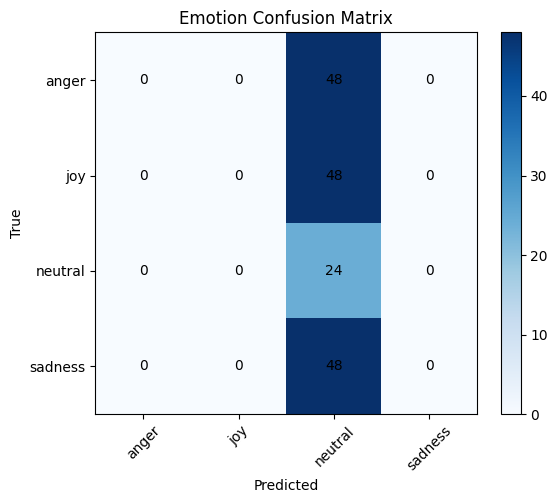

In [39]:
# %% ───────────────────────── 8. Confusion matrix ────────────────
labels = sorted(res_df["mapped_emotion"].unique())
cm = confusion_matrix(res_df["mapped_emotion"], res_df["top_emotion"], labels=labels)

plt.figure(figsize=(6,5))
plt.imshow(cm, cmap="Blues"); plt.colorbar()
plt.xticks(range(len(labels)), labels, rotation=45)
plt.yticks(range(len(labels)), labels)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Emotion Confusion Matrix")
for (i,j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha="center", va="center")
plt.tight_layout(); plt.show()

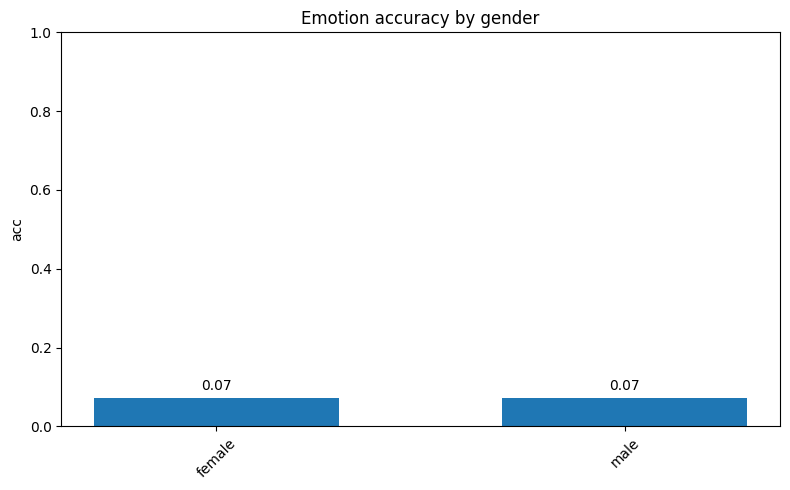

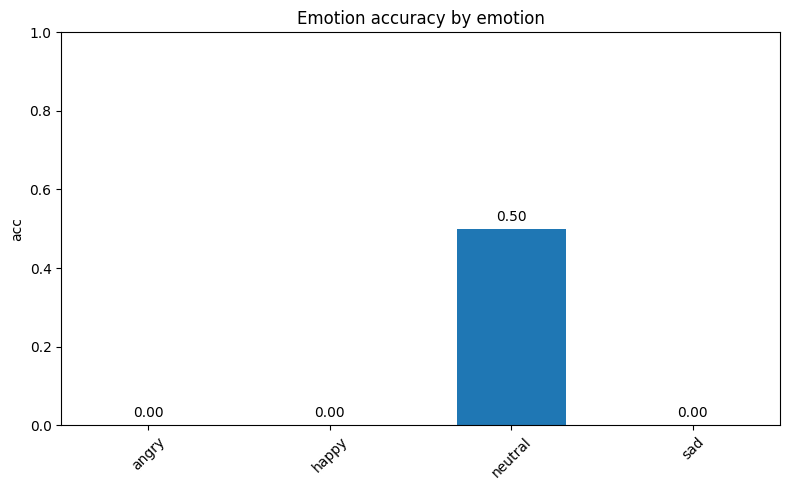

In [40]:
# %% ───────────────────────── 9. Gender & emotion breakdown ──────
by_gender  = res_df.groupby("gender").agg(acc=("match","mean"), wer=("wer","mean"))
by_emotion = res_df.groupby("emotion").agg(acc=("match","mean"), wer=("wer","mean"))

def bar(df, title, col="acc"):
    plt.figure(figsize=(8,5))
    x = np.arange(len(df))
    plt.bar(x, df[col], 0.6)
    plt.xticks(x, df.index, rotation=45)
    plt.ylim(0,1); plt.ylabel(col); plt.title(title)
    for i,v in enumerate(df[col]): plt.text(i, v+0.02, f"{v:.2f}", ha="center")
    plt.tight_layout(); plt.show()

bar(by_gender, "Emotion accuracy by gender")
bar(by_emotion, "Emotion accuracy by emotion")